In [97]:
# imports

%matplotlib inline

from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats.stats import pearsonr

In [55]:
# create Mongo Client to retrieve collections

client = MongoClient('localhost', 27017)
client.database_names()
reddit_db = client.reddit
collection = reddit_db.post

In [56]:
# convert the collection into a Python dataframe

collection.find_one()
reddit_df = pd.DataFrame(list(collection.find()))

In [57]:
# delete _id column 

reddit_df.drop(['_id'], axis = 1, inplace = True)
reddit_df.head()

,comments,date,label,link,title,upvotes
0,[],[],[],[],"[LPT: If you're looking for a new tech job, pu...",35
1,[40 comments],[2016-05-21T00:03:42+00:00],[],[self.technology],[Got a tech question or want to discuss tech? ...,13
2,[1438 comments],[2016-05-25T09:57:29+00:00],[Business],[arstechnica.com],[Microsoft bangs the final nail in Nokia Devic...,5176
3,[135 comments],[2016-05-25T10:56:10+00:00],[Energy],[electrek.co],[US Department of Energy wants 100% solar powe...,2584
4,[4 comments],[2016-05-25T17:40:42+00:00],[Security],[techdirt.com],"[Congrats, FBI, You've Now Convinced Silicon V...",379


In [58]:
# convert all columns into strings

index_list = list(reddit_df.columns.values)
index_list = index_list[:6]

for i in index_list:
    for i in reddit_df[i]:
        if len(i) == 0:
            i.append("0")

for i in index_list:
    reddit_df[i] = ["".join(x).encode('ascii','ignore') for x in reddit_df[i]]

reddit_df.head()

,comments,date,label,link,title,upvotes
0,0,0,0,0,"LPT: If you're looking for a new tech job, put...",35
1,40 comments,2016-05-21T00:03:42+00:00,0,self.technology,Got a tech question or want to discuss tech? W...,13
2,1438 comments,2016-05-25T09:57:29+00:00,Business,arstechnica.com,Microsoft bangs the final nail in Nokia Device...,5176
3,135 comments,2016-05-25T10:56:10+00:00,Energy,electrek.co,US Department of Energy wants 100% solar power...,2584
4,4 comments,2016-05-25T17:40:42+00:00,Security,techdirt.com,"Congrats, FBI, You've Now Convinced Silicon Va...",379


In [59]:
# filter out 0 values in date (this means that the post is an ad)
# retrieve the number only from comments column

reddit_df = reddit_df[reddit_df['date'] != '0']
reddit_df = reddit_df[reddit_df['upvotes'] != '']

reddit_df['comments'] = reddit_df['comments'].apply(lambda x: x.split(' ')[0])

reddit_df = reddit_df[reddit_df['comments'] != 'comment']

In [138]:
reddit_df = reddit_df[reddit_df['label'] != 'R1.i: guidelines']
reddit_df = reddit_df[reddit_df['label'] != 'R1.iii: tech support/question/help R1.vi: customer support']

In [139]:
# convert 'upvotes' and 'comments' column from string into int

reddit_df['upvotes'] = [int(float(x)) for x in reddit_df['upvotes']]
reddit_df['comments'] = [int(float(x)) for x in reddit_df['comments']]

In [61]:
# create a column to get ratio of 'upvotes' : 'comments'

reddit_df['up_com'] = reddit_df['upvotes']/reddit_df['comments']
reddit_df.drop_duplicates('title', keep = 'first', inplace = True)

In [63]:
# change format for date column

new_date = []
for i in reddit_df['date']:
    if i == 0:
        pass
    else:
        new_date.append(i[0:10])
reddit_df["Date"] = new_date

In [162]:
# group dataframe by date and label

non_zero = reddit_df[reddit_df['label'] != '0']
temp = non_zero.groupby(['label']).mean()

In [144]:
label_ind = sorted(reddit_df.label.unique())

['0', 'AI', 'AdBlock WARNING', 'Biotech', 'Business', 'Comcast', 'Discussion', 'Energy', 'Entertainment', 'Hardware', 'Nanotech', 'Net Neutrality', 'Networking', 'Old News', 'Politics', 'Robotics', 'Security', 'Software', 'Space', 'Transport', 'Wireless']


(0.86191557798798801, 3.7752471962070932e-158)


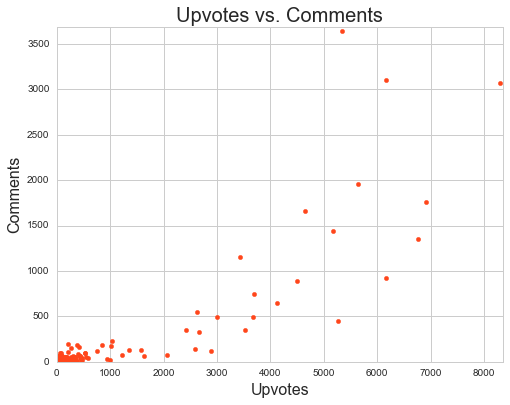

(0.61139732065425711, 5.2365083034586033e-49)


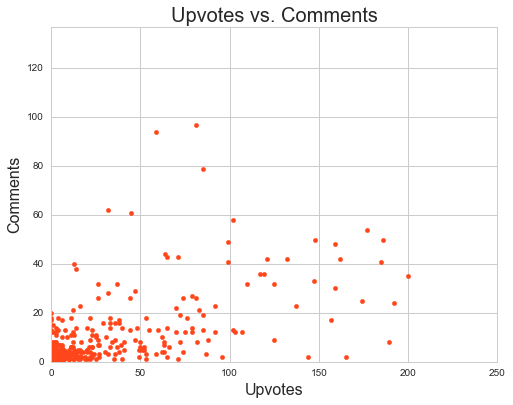

In [171]:
# Upvotes vs. Comments: scatter graphs

sns.set_style("whitegrid")
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(reddit_df['upvotes'], reddit_df['comments'], color = "#FF461B")
plt.title('Upvotes vs. Comments', fontsize = 20)
plt.ylabel('Comments', fontsize = 16)
plt.xlabel('Upvotes', fontsize = 16)
plt.xlim([0, max(reddit_df['upvotes'])+50])
plt.ylim([0, max(reddit_df['comments'])+40])
print pearsonr(reddit_df['upvotes'], reddit_df['comments'])

plt.show()

under_200 = reddit_df[reddit_df['upvotes'] <= 200]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(under_200['upvotes'], under_200['comments'], color = "#FF461B")
plt.title('Upvotes vs. Comments', fontsize = 20)
plt.ylabel('Comments', fontsize = 16)
plt.xlabel('Upvotes', fontsize = 16)
plt.xlim([0, max(under_200['upvotes'])+50])
plt.ylim([0, max(under_200['comments'])+40])
print pearsonr(under_200['upvotes'], under_200['comments'])

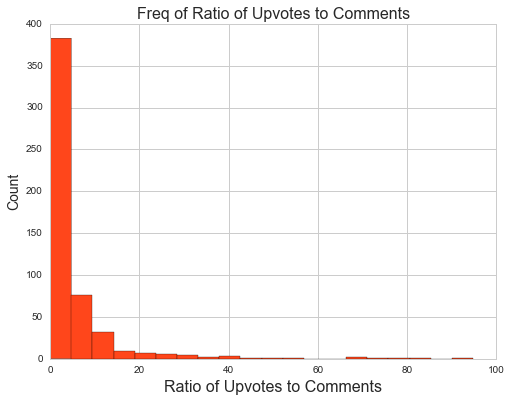

In [172]:
# histogram for frequency of Ratio of Upvotes

sns.set_style("whitegrid")
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.hist(reddit_df.up_com, bins = 20, color = "#FF461B")
plt.xlabel('Ratio of Upvotes to Comments', fontsize = 16)
plt.ylabel('Count', fontsize = 14)
plt.title("Freq of Ratio of Upvotes to Comments", fontsize = 16)

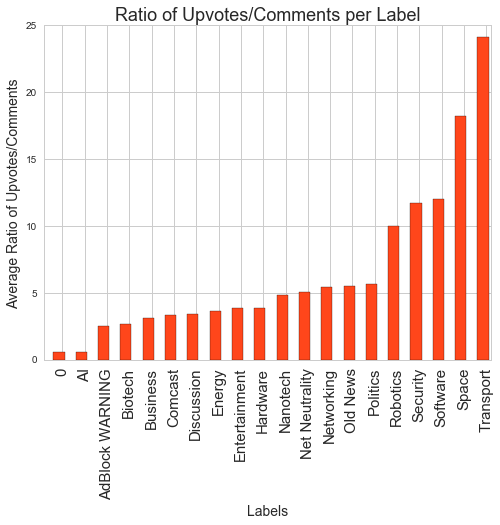

In [161]:
# bar graph for ratio of Upvotes/Comments per Label

pos = np.arange(len(label_ind[1:])) + 0.4
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pos, sorted(temp['up_com']), width = .5, color = "#FF461B")
plt.xticks(pos + .4, label_ind, fontsize = 15, rotation = 'vertical')
plt.title("Ratio of Upvotes/Comments per Label", fontsize = 18)
plt.xlabel("Labels", fontsize = 14)
plt.ylabel("Average Ratio of Upvotes/Comments", fontsize = 14)

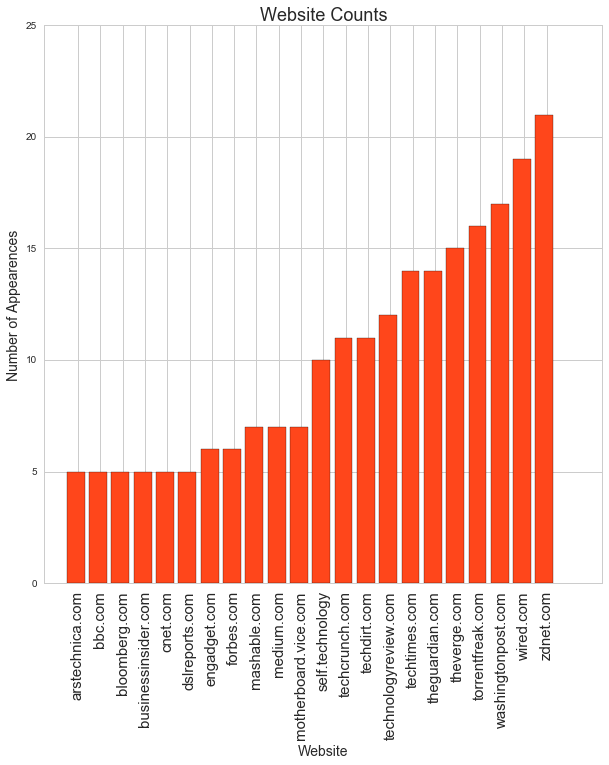

In [206]:
# links analysis 

links = non_zero.groupby(['link']).count()
link_df = links[links['upvotes'] >= 5]

pos = np.arange(len(link_df.index)) + 1

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pos, sorted(link_df['up_com']), width = .8, color = "#FF461B")
plt.xticks(pos + .5, link_df.index, fontsize = 15, rotation = 'vertical')
plt.title("Website Counts", fontsize = 18)
plt.xlabel("Website", fontsize = 14)
plt.ylabel("Number of Appearences", fontsize = 14)